# Machine Learning Project Checklist

1. Frame the problem and look at the big picture.

2. Get the data.

3. **Explore the data to gain insights.**

4. Explore many different models and short-list the best ones.

5. Fine-tune your models and combine them into a great solution.

6. Present your solution.

## 3. Explore the data to gain insigths
- Study each attribute and its characteristics
- Visualize the data

In [1]:
import os

In [2]:
REPO_DIR = os.path.join(os.environ['USERPROFILE'], 'repos')
PROJ_DIR = os.path.join(REPO_DIR, 'real_estate_machine_learning')
os.chdir(PROJ_DIR)

In [3]:
DATA_DIR = './data'
RPT_DIR = './reports'
INPUT_DIR = '../real_estate_hungary/output'
FILENAME = 'ForSaleRent_20181101.csv'
SCRAPE_DATE = os.path.splitext(FILENAME)[0].split('_')[1]
INPUT_FILEPATH=os.path.join(INPUT_DIR, FILENAME)
EXT_DIR = os.path.join(DATA_DIR, 'ext')
RAW_DIR = os.path.join(DATA_DIR, 'raw')
INT_DIR = os.path.join(DATA_DIR, 'interim')
PRO_DIR = os.path.join(DATA_DIR, 'processed')
IMG_DIR = os.path.join(DATA_DIR, 'img')

In [4]:
import pandas as pd, numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
import datetime
import matplotlib.pyplot as plt

In [5]:
import src.preparation as prep
import src.processing as proc
from src.processing import extract_num
import src.visualization as viz
from src.utils import *
%matplotlib inline

## Loading datasets for Classification
In the *Preparation* step I have gathered GPS coordinates of:
- Boundaries of Budapest and its sub-districts
- Inhabited areas of Budapest e.g. river, island etc.
- Boundaries of agglomeration of Budapest
- Listed properties for-sale and for-rent in Budapest

Purpose of getting of these datasets is to create a classification model, which can distinguish among 3 classes:
1. Uninhabited area in Budapest
2. Inhabited area in Budapest
3. Area outside of Budapest

In [6]:
uninhabited = pd.read_csv(os.path.join(EXT_DIR, 'uninhabited.csv'), encoding='utf8')
boundaries = pd.read_csv(os.path.join(EXT_DIR, 'boundaries.csv'), encoding='utf8')
agglomeration = pd.read_csv(os.path.join(EXT_DIR, 'agglomeration.csv'), encoding='utf8')
listings_raw = pd.read_csv(INPUT_FILEPATH, encoding='utf8')
listings = proc.transform_naming(listings_raw)

In [7]:
uninhabited.head(3)

,id,lat,lon
0,35966076,47.390312,19.009000
1,35966077,47.390487,19.008688
2,35966078,47.390775,19.008289


In [8]:
boundaries.head(3)

,id,lat,lon,name,postal_code
0,2366619156,47.600624,19.114079,1044 Budapest IV. kerület,1044
1,1768916389,47.600558,19.114009,1044 Budapest IV. kerület,1044
2,1768916389,47.600558,19.114009,1044 Budapest IV. kerület,1044


In [9]:
agglomeration.head(3)

,id,lat,lon,name
0,303616978,47.305404,18.858317,Százhalombatta
1,373873292,47.304640,18.860401,Százhalombatta
2,373873296,47.306042,18.864663,Százhalombatta


In [10]:
listings[['lat', 'lng']].head(3)

,lat,lng
0,47.460680,19.048690
1,47.529858,19.079060
2,47.529730,19.078869


Renaming the columns to common name:

In [11]:
common_col_name = {'lon' : 'lng'}

In [12]:
for df in [uninhabited, boundaries, agglomeration]:
    df.rename(columns=common_col_name, inplace=True)

Adding classes:

In [13]:
uninhabited['label'] = 'uninhabited'
boundaries['label'] = 'inhabited_budapest'
agglomeration['label'] = 'outside_of_budapest'
listings['label'] = 'inhabited_budapest'

In [14]:
agg_min_gps=agglomeration[['lng', 'lat']].min()
agg_max_gps=agglomeration[['lng', 'lat']].max()
pic_ratio=(agg_max_gps['lat']-agg_min_gps['lat'])/(agg_max_gps['lng']-agg_min_gps['lng'])
print(pic_ratio)

0.8305150960692917


In [15]:
opt_fig_size=viz.calc_fig_size(pic_ratio, 2.5)

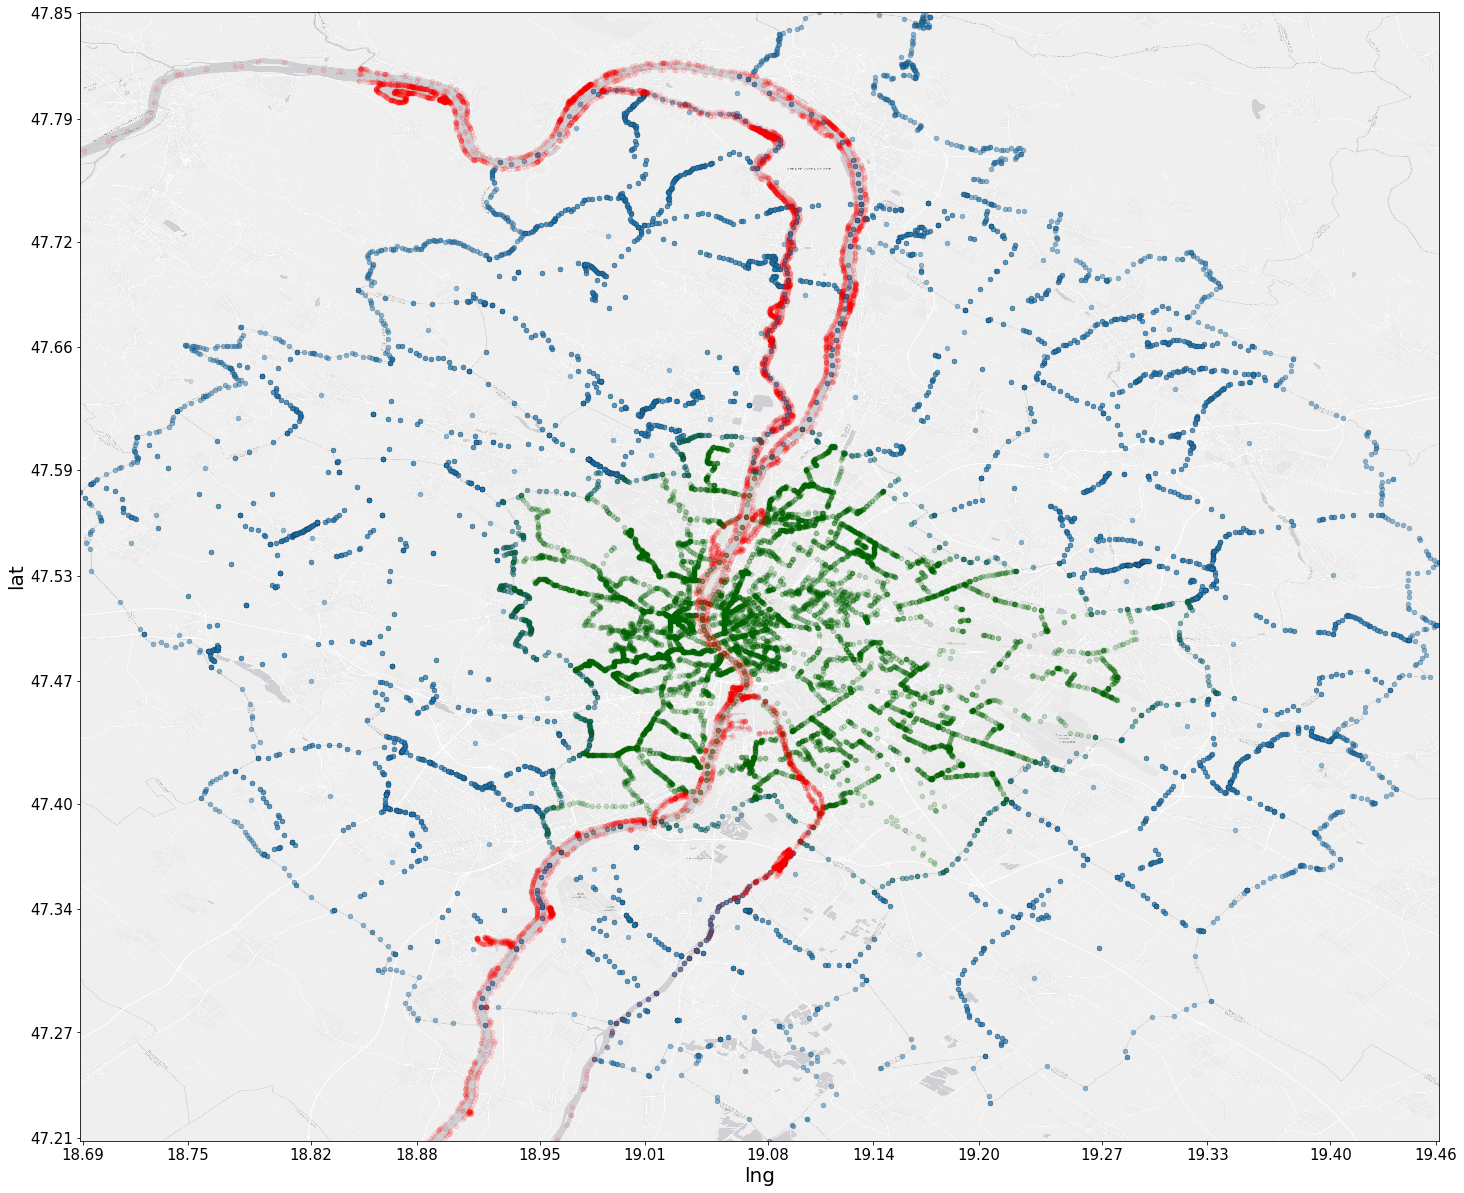

In [16]:
fig, ax = viz.plot_scatter_map(x=agglomeration['lng'], y=agglomeration['lat'], xlabel='Longitude', ylabel='Latitude', figsize=opt_fig_size, dpi=160, alpha=0.5)
boundaries.plot(kind='scatter', x='lng', y='lat', ax=ax, c='darkgreen', alpha=0.1)
uninhabited.plot(kind='scatter', x='lng', y='lat', ax=ax, c='r', alpha=0.1)
plt.show()

There are overlapping areas among the classes. Solution is to filter out common boundaries:

In [17]:
cols=['lat', 'lng', 'label']
boundaries_not_in_uninhabited=~boundaries.lat.isin(uninhabited.lat)&~boundaries.lng.isin(uninhabited.lng)
boundaries_not_in_agglomeration=~boundaries.lat.isin(agglomeration.lat)&~boundaries.lng.isin(agglomeration.lng)
agglomeration_not_in_uninhabited=~agglomeration.lat.isin(uninhabited.lat)&~agglomeration.lng.isin(uninhabited.lng)

Combined dataset:

In [18]:
budapest = pd.concat([boundaries.loc[boundaries_not_in_uninhabited&boundaries_not_in_agglomeration, cols],
                      agglomeration.loc[agglomeration_not_in_uninhabited, cols],
                      uninhabited.loc[:,cols],
                      listings.loc[:, cols]]).drop_duplicates()

In [19]:
bound_min_gps=boundaries.min()
bound_max_gps=boundaries.max()
bp_min_lng_mask=(bound_min_gps['lng']<=budapest.lng)&(budapest.lng<=bound_max_gps['lng'])
bp_max_lat_mask=(bound_min_gps['lat']<=budapest.lat)&(budapest.lat<=bound_max_gps['lat'])

In [20]:
budapest=budapest[bp_min_lng_mask&bp_max_lat_mask]

In [21]:
budapest['label_factor'] = budapest.label.factorize()[0]

In [22]:
budapest[['label', 'label_factor']].drop_duplicates()

,label,label_factor
0,inhabited_budapest,0
43,outside_of_budapest,1
0,uninhabited,2


Final, cleaned dataset:

In [23]:
pic_ratio=(bound_max_gps['lat']-bound_min_gps['lat'])/(bound_max_gps['lng']-bound_min_gps['lng'])
print(pic_ratio)

0.642859879249475


In [24]:
opt_fig_size=viz.calc_fig_size(pic_ratio, 2.5)

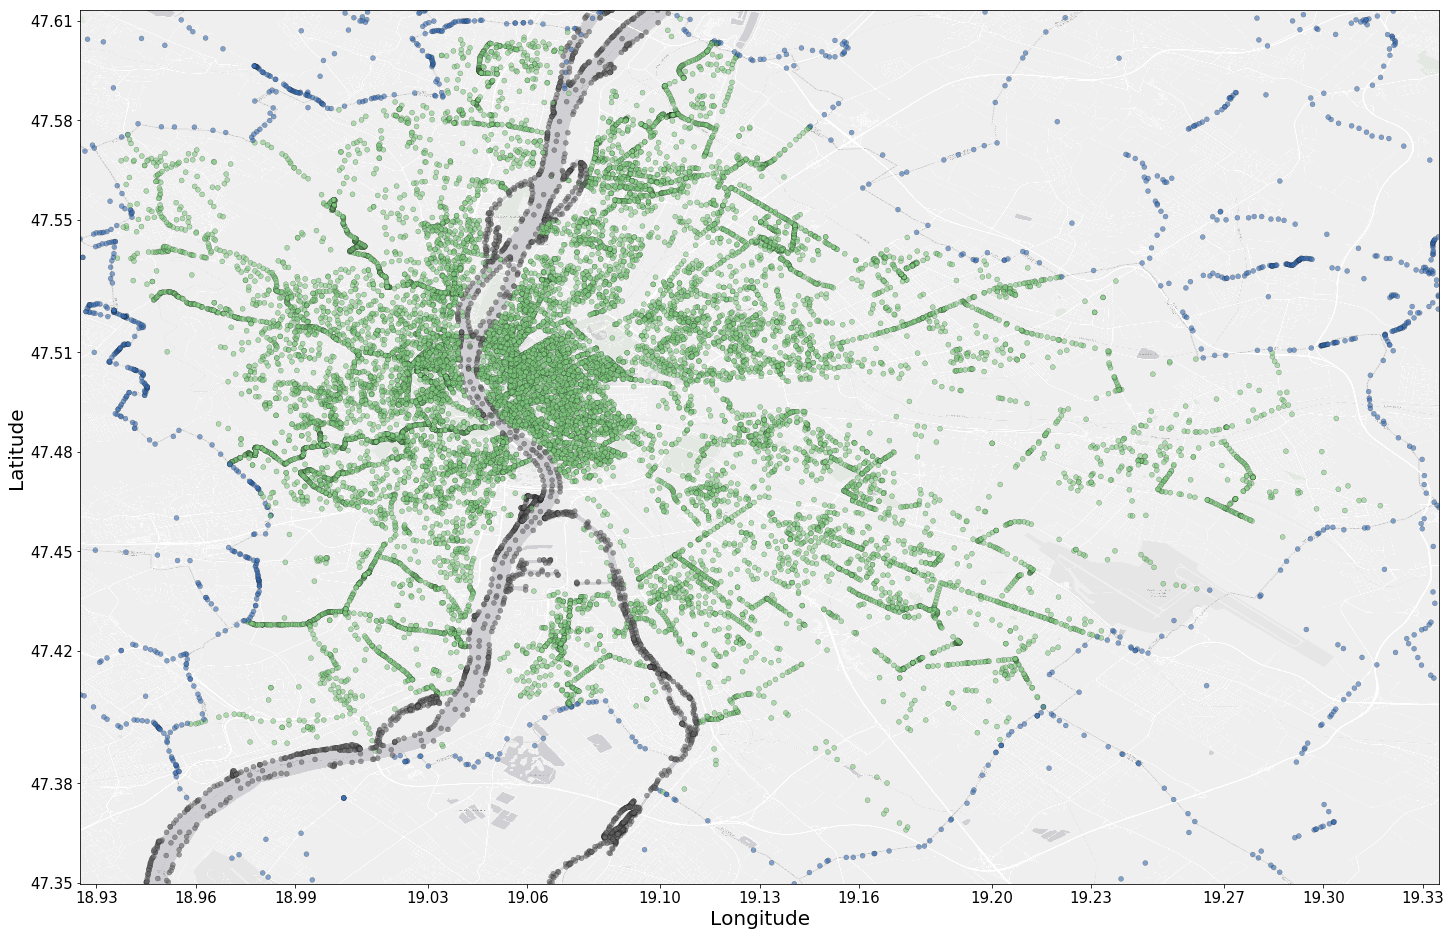

In [25]:
fig, ax = viz.plot_scatter_map(x=budapest['lng'], y=budapest['lat'], c=budapest['label_factor'], colormap='Accent', cbar=False, xlabel='Longitude', ylabel='Latitude', figsize=opt_fig_size, dpi=160, alpha=0.6)

Class probabilities, as benchmark of the classification:

In [26]:
print('Total number of records in the dataset: {0:,}'.format(len(budapest)))
budapest[['label', 'label_factor']].groupby('label').count()/len(budapest)

Total number of records in the dataset: 19,037


,label_factor
label,
inhabited_budapest,0.830225
outside_of_budapest,0.059253
uninhabited,0.110522


Stratified splitting for train and test set:

In [27]:
train_bp, test_bp, y_train_bp, y_test_bp = train_test_split(budapest[['lat', 'lng', 'label', 'label_factor']],
                                                                budapest.label,
                                                                random_state=777,
                                                                test_size=0.2,
                                                                train_size=0.8,
                                                                stratify=budapest.label)

In [28]:
len(train_bp)/len(budapest), len(test_bp)/len(budapest)

(0.7999684824289541, 0.20003151757104587)

Validation of stratified sampling:

In [29]:
train_bp[['label', 'label_factor']].groupby('label').count()/len(train_bp)

,label_factor
label,
inhabited_budapest,0.830258
outside_of_budapest,0.059229
uninhabited,0.110513


Saving the processed and cleaned dataset:

In [30]:
fns = ['training_class_{}.csv', 'testing_class_{}.csv']
fns_date = [n.format(SCRAPE_DATE) for n in fns]
dfs =[train_bp, test_bp]

In [31]:
for fn, df in zip(fns_date, dfs):
    df.to_csv(os.path.join(PRO_DIR, fn), encoding='utf8', index=False)